In [ ]:
# Block 1: Install & Import Libraries
!pip install -q tldextract xgboost scikit-learn pandas imbalanced-learn

import pandas as pd
import numpy as np
import tldextract
import xgboost as xgb
from pathlib import Path
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score
from xgboost import XGBClassifier
import math
import re
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import io
import pickle
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

print('Libraries installed and imported successfully.')

Libraries installed and imported successfully.


In [ ]:
# Block 2: Define Feature Extraction Engine (Enhanced)
# Suspicious words that indicate urgency or credential harvesting
SUSPICIOUS_KEYWORDS = [
    'login', 'verify', 'update', 'account', 'secure', 'banking',
    'confirm', 'signin', 'password', 'wallet', 'crypto', 'admin', 'service'
]

# Suspicious TLDs commonly used in phishing
SUSPICIOUS_TLDS = ['.tk', '.ml', '.ga', '.cf', '.gq', '.xyz', '.top', '.club', '.work', '.buzz']

def calculate_entropy(text):
    """Calculates randomness. High entropy (e.g., 'a83-1z.com') = Suspicious."""
    if not text:
        return 0
    entropy = 0
    for x in range(256):
        p_x = float(text.count(chr(x))) / len(text)
        if p_x > 0:
            entropy += - p_x * math.log(p_x, 2)
    return entropy

def extract_features(url):
    features = {}

    # Ensure URL scheme exists for parsing
    if not isinstance(url, str):
        url = str(url)
    original_url = url
    if not url.startswith(('http://', 'https://')):
        url = 'http://' + url

    try:
        parsed = urlparse(url)
        ext = tldextract.extract(url)

        # "full_domain" includes subdomain + domain + suffix (e.g., mail.google.co.uk)
        full_domain = ".".join(part for part in [ext.subdomain, ext.domain, ext.suffix] if part)
        path = parsed.path
        query = parsed.query

        # --- CORE DOMAIN FEATURES ---
        features['domain_length'] = len(full_domain)
        features['qty_dot_domain'] = full_domain.count('.')
        features['qty_hyphen_domain'] = full_domain.count('-')
        features['domain_entropy'] = calculate_entropy(full_domain)

        # Check if domain contains an IP address (High Phishing Indicator)
        ip_pattern = r'^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$'
        features['is_ip'] = 1 if re.match(ip_pattern, full_domain) else 0

        # --- URL STRUCTURE FEATURES ---
        features['url_length'] = len(original_url)
        features['qty_at_symbol'] = url.count('@')  # Phishing trick to hide real domain
        features['qty_ampersand'] = url.count('&')
        features['qty_percent'] = url.count('%')  # URL encoding abuse

        # --- PATH ANALYSIS (Improved) ---
        features['qty_slash_url'] = url.count('/')
        features['qty_hyphen_path'] = path.count('-')
        
        # Query parameters can indicate tracking or phishing
        features['qty_params'] = len(query.split('&')) if query else 0
        features['qty_equal'] = url.count('=')

        # --- SEMANTIC FEATURES (Enhanced) ---
        features['sus_keywords_count'] = sum(1 for word in SUSPICIOUS_KEYWORDS if word in url.lower())
        features['qty_double_slash'] = url.count('//')  # Should be 1 normally (http://)
        
        # Suspicious TLD detection
        tld_with_dot = '.' + ext.suffix if ext.suffix else ''
        features['has_suspicious_tld'] = 1 if tld_with_dot.lower() in SUSPICIOUS_TLDS else 0

        # Subdomain depth (more subdomains = more suspicious)
        features['subdomain_depth'] = len(ext.subdomain.split('.')) if ext.subdomain else 0

        # Character analysis
        features['digit_ratio'] = sum(c.isdigit() for c in full_domain) / len(full_domain) if full_domain else 0
        features['special_char_count'] = sum(1 for c in full_domain if not c.isalnum() and c != '.')
        
        # Suspicious patterns
        features['has_port'] = 1 if parsed.port else 0
        features['has_tilde'] = 1 if '~' in url else 0  # Often used in phishing

    except Exception:
        return None  # Return None if parsing fails

    return features

print('Enhanced Feature Extraction Logic Defined.')
print(f'Total features: {len(extract_features("https://example.com/test"))}')

Enhanced Feature Extraction Logic Defined.
Total features: 16


In [ ]:
# Block 3: Load Data, De-bias, and Extract Features
import os

# Try to load from runtime first, fall back to upload if not found
if os.path.exists('master_data_1.csv'):
    print('Loading master_data_1.csv from runtime...')
    df_raw = pd.read_csv('master_data_1.csv')
    df_raw['source'] = 'master_data_1'
else:
    print('master_data_1.csv not found in runtime.')
    print('Please upload one or more CSV files (e.g., dataset_a.csv, dataset_b.csv, master_data_1.csv):')
    uploaded = files.upload()

    dfs = []
    for filename, content in uploaded.items():
        source_name = Path(filename).stem
        temp_df = pd.read_csv(io.BytesIO(content))
        temp_df['source'] = source_name
        dfs.append(temp_df)
        print(f'Loaded {len(temp_df)} rows from {filename}')

    df_raw = pd.concat(dfs, ignore_index=True)

# Basic cleanup
df_raw = df_raw.dropna(subset=['url', 'label'])
df_raw['label'] = df_raw['label'].astype(int)
df_raw = df_raw.drop_duplicates(subset='url')

print('Rows by source (no capping):')
print(df_raw['source'].value_counts())

# Balance classes (downsample majority to the minority size)
class_counts = df_raw['label'].value_counts()
minority_size = class_counts.min()
balanced_parts = []
for label, g in df_raw.groupby('label'):
    balanced_parts.append(g.sample(n=minority_size, random_state=42))
df_balanced = pd.concat(balanced_parts, ignore_index=True).sample(frac=1.0, random_state=42).reset_index(drop=True)

print('\nClass distribution after balancing:')
print(df_balanced['label'].value_counts())

# Apply feature extraction
print('Extracting features...')
feature_data = df_balanced['url'].apply(lambda x: pd.Series(extract_features(x)))
final_df = pd.concat([feature_data, df_balanced[['label', 'source']]], axis=1)
final_df = final_df.dropna()

print(f'Preprocessing complete. Final shape: {final_df.shape}')
print(final_df.head())

Loading master_data_1.csv from runtime...
Rows by source (no capping):
source
master_data_1    788517
Name: count, dtype: int64

Class distribution after balancing:
label
0    260445
1    260445
Name: count, dtype: int64
Extracting features...
Preprocessing complete. Final shape: (520873, 18)
   domain_length  qty_dot_domain  qty_hyphen_domain  domain_entropy  is_ip  \
0           14.0             2.0                0.0        3.182006    0.0   
1           23.0             2.0                0.0        3.827910    0.0   
2           20.0             1.0                0.0        3.546439    0.0   
3            7.0             1.0                0.0        2.521641    0.0   
4           17.0             2.0                0.0        3.292770    0.0   

   path_length  qty_slash_path  qty_hyphen_path  sus_keywords_count  \
0         44.0             4.0              0.0                 0.0   
1          1.0             1.0              0.0                 0.0   
2          6.0          

In [ ]:
# Block 4: Split Data (Train / Validation / Test)

# Separate inputs (X) and target (y)
X = final_df.drop(['label', 'source'], axis=1)
y = final_df['label']

# First split off the test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Split the remainder into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)  # 0.1765 of 85% ≈ 15% of total

print('Data split successfully:')
print(f'   Training samples:     {len(X_train)}')
print(f'   Validation samples:   {len(X_val)}')
print(f'   Testing samples:      {len(X_test)}')

Data split successfully:
   Training samples:     364598
   Validation samples:   78144
   Testing samples:      78131


In [ ]:
# Block 5: Train XGBoost Model with Enhanced Hyperparameters
print('Training model with optimized parameters...')

# Compute class weight to offset imbalance
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / pos if pos > 0 else 1.0

# Convert to DMatrix for native training API
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
val_dmatrix = xgb.DMatrix(X_val, label=y_val)

eval_list = [(train_dmatrix, 'train'), (val_dmatrix, 'val')]

# Enhanced parameters for better accuracy
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'aucpr', 'auc'],
    'eta': 0.03,              # slower learning for better generalization
    'max_depth': 8,           # deeper trees to capture complex patterns
    'min_child_weight': 2.0,  # more conservative splits
    'subsample': 0.85,
    'colsample_bytree': 0.85,
    'gamma': 0.15,
    'reg_alpha': 0.5,         # increased L1 regularization
    'reg_lambda': 2.0,        # increased L2 regularization
    'tree_method': 'hist',
    'random_state': 42,
    'scale_pos_weight': scale_pos_weight
}

booster = xgb.train(
    params,
    train_dmatrix,
    num_boost_round=3000,     # train for exactly 3000 rounds
    evals=eval_list,
    verbose_eval=200         # show progress every 200 rounds
)

best_iteration = booster.best_iteration if hasattr(booster, 'best_iteration') else None
if best_iteration is None:
    best_iteration = booster.num_boosted_rounds() - 1
best_ntree_limit = best_iteration + 1

print(f'Best iteration: {best_iteration}')
print(f'Best ntree limit: {best_ntree_limit}')
print('Model training complete.')

Training model with optimized parameters...
[0]	train-logloss:0.67814	train-aucpr:0.91442	train-auc:0.90288	val-logloss:0.67817	val-aucpr:0.91432	val-auc:0.90295
[200]	train-logloss:0.32568	train-aucpr:0.94334	train-auc:0.93482	val-logloss:0.32746	val-aucpr:0.94275	val-auc:0.93388
[400]	train-logloss:0.30173	train-aucpr:0.95119	train-auc:0.94444	val-logloss:0.30600	val-aucpr:0.94967	val-auc:0.94229
[600]	train-logloss:0.28475	train-aucpr:0.95661	train-auc:0.95087	val-logloss:0.29166	val-aucpr:0.95414	val-auc:0.94764
[800]	train-logloss:0.27279	train-aucpr:0.96025	train-auc:0.95511	val-logloss:0.28230	val-aucpr:0.95692	val-auc:0.95092
[1000]	train-logloss:0.26363	train-aucpr:0.96292	train-auc:0.95820	val-logloss:0.27554	val-aucpr:0.95882	val-auc:0.95319
[1200]	train-logloss:0.25653	train-aucpr:0.96493	train-auc:0.96049	val-logloss:0.27074	val-aucpr:0.96016	val-auc:0.95474
[1400]	train-logloss:0.25083	train-aucpr:0.96648	train-auc:0.96226	val-logloss:0.26719	val-aucpr:0.96112	val-auc:0.9

Finding optimal threshold on validation set...
Optimal threshold: 0.440 (Validation F1: 0.8920)

--- Results with default threshold (0.5) ---
Train: 91.04% | Val: 89.41% | Test: 89.42%

--- Results with optimized threshold (0.440) ---
Train: 90.95% | Val: 89.28% | Test: 89.32%

AUC metrics (test):
ROC-AUC: 0.9596 | PR-AUC: 0.9642

Classification report (test with optimized threshold):
              precision    recall  f1-score   support

           0     0.8903    0.8970    0.8936     39067
           1     0.8962    0.8894    0.8928     39064

    accuracy                         0.8932     78131
   macro avg     0.8933    0.8932    0.8932     78131
weighted avg     0.8933    0.8932    0.8932     78131



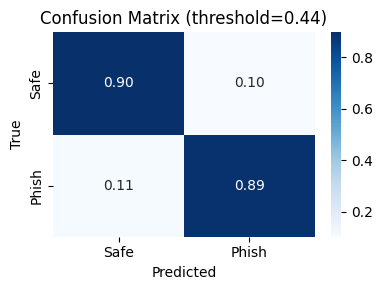


Top 10 Feature Importances:
  is_https: 1140.05
  is_ip: 128.89
  qty_dot_domain: 77.12
  subdomain_depth: 26.85
  has_suspicious_tld: 21.16
  path_length: 14.47
  sus_keywords_count: 9.61
  digit_ratio: 9.45
  qty_hyphen_domain: 9.39
  qty_slash_path: 9.02


In [ ]:
# Block 6: Evaluate Performance + Threshold Optimization
from sklearn.metrics import f1_score

# Prepare DMatrices
train_dmatrix = xgb.DMatrix(X_train)
val_dmatrix = xgb.DMatrix(X_val)
test_dmatrix = xgb.DMatrix(X_test)

# Predictions using the best iteration
train_proba = booster.predict(train_dmatrix, iteration_range=(0, best_ntree_limit))
val_proba = booster.predict(val_dmatrix, iteration_range=(0, best_ntree_limit))
test_proba = booster.predict(test_dmatrix, iteration_range=(0, best_ntree_limit))

# --- THRESHOLD OPTIMIZATION ---
print('Finding optimal threshold on validation set...')
thresholds = np.arange(0.30, 0.70, 0.01)
best_threshold = 0.5
best_f1 = 0

for thresh in thresholds:
    preds = (val_proba > thresh).astype(int)
    f1 = f1_score(y_val, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

print(f'Optimal threshold: {best_threshold:.3f} (Validation F1: {best_f1:.4f})')

# --- EVALUATE WITH BOTH THRESHOLDS ---
print('\n--- Results with default threshold (0.5) ---')
threshold = 0.5
train_pred = (train_proba > threshold).astype(int)
val_pred = (val_proba > threshold).astype(int)
test_pred = (test_proba > threshold).astype(int)

train_acc = accuracy_score(y_train, train_pred)
val_acc = accuracy_score(y_val, val_pred)
test_acc = accuracy_score(y_test, test_pred)
print(f'Train: {train_acc * 100:.2f}% | Val: {val_acc * 100:.2f}% | Test: {test_acc * 100:.2f}%')

print(f'\n--- Results with optimized threshold ({best_threshold:.3f}) ---')
train_pred_opt = (train_proba > best_threshold).astype(int)
val_pred_opt = (val_proba > best_threshold).astype(int)
test_pred_opt = (test_proba > best_threshold).astype(int)

train_acc_opt = accuracy_score(y_train, train_pred_opt)
val_acc_opt = accuracy_score(y_val, val_pred_opt)
test_acc_opt = accuracy_score(y_test, test_pred_opt)
print(f'Train: {train_acc_opt * 100:.2f}% | Val: {val_acc_opt * 100:.2f}% | Test: {test_acc_opt * 100:.2f}%')

# Use optimized threshold for final evaluation
final_test_pred = test_pred_opt

roc_test = roc_auc_score(y_test, test_proba)
pr_test = average_precision_score(y_test, test_proba)

print('\nAUC metrics (test):')
print(f'ROC-AUC: {roc_test:.4f} | PR-AUC: {pr_test:.4f}')

print('\nClassification report (test with optimized threshold):')
print(classification_report(y_test, final_test_pred, digits=4))

cm = confusion_matrix(y_test, final_test_pred, normalize='true')
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Safe', 'Phish'], yticklabels=['Safe', 'Phish'])
plt.title(f'Confusion Matrix (threshold={best_threshold:.2f})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Feature importance
print('\nTop 10 Feature Importances:')
importance = booster.get_score(importance_type='gain')
importance_sorted = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:10]
for feat, score in importance_sorted:
    print(f'  {feat}: {score:.2f}')

In [ ]:
# Block 7: Save and Download Model
model_filename = 'phishing_xgb_model.json'

if 'booster' not in locals():
    raise RuntimeError('Training booster not found. Run Block 5 before saving.')

# Save using the best trees discovered during early stopping
booster.save_model(model_filename)
print(f"Model saved as '{model_filename}'")

# Trigger download
files.download(model_filename)

Model saved as 'phishing_xgb_model.json'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_url = 'https://www.merriam-webster.com/dictionary/where'
# Extract features for the new URL
url_features = extract_features(test_url)

if url_features is not None:
    # Convert features to a DataFrame (matching the model's expected input format)
    url_df = pd.DataFrame([url_features])

    # Ensure column order matches training data, fill missing with 0 if any
    # (though extract_features should produce all expected columns)
    missing_cols = set(X_train.columns) - set(url_df.columns)
    for c in missing_cols:
        url_df[c] = 0
    url_df = url_df[X_train.columns] # Reorder columns to match training data

    # Convert to DMatrix
    test_url_dmatrix = xgb.DMatrix(url_df)

    # Get prediction probability
    prediction_proba = booster.predict(test_url_dmatrix, iteration_range=(0, best_ntree_limit))[0]

    # Classify based on the best_threshold found earlier
    prediction_class = 1 if prediction_proba > best_threshold else 0

    print(f"\nPrediction for '{test_url}':")
    print(f"  Probability (Phishing): {prediction_proba:.4f}")
    print(f"  Predicted Class (0=Safe, 1=Phishing): {prediction_class}")
else:
    print(f"Could not extract features for URL: {test_url}")


Prediction for 'tiendaeverton.cl':
  Probability (Phishing): 0.2691
  Predicted Class (0=Safe, 1=Phishing): 0
